# Image classification

<h1 style="color:Tomato;">
The Data set size is only 1200, So i had to do Data Augmentation and created my dataset szie more than 7000

Refer below link to check my Data Augmentation done

https://github.com/shivprasad94/annotation_converter/blob/main/autoaugment.py

## Import TensorFlow and other libraries

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Create a dataset

Define some parameters for the loader:

In [24]:
BATCH_SIZE = 8
img_height = 480
img_width = 480

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [25]:
train_dir = r'C:/AIML_COE/swissre_Assignment/Problem2/Dataset/train'
validation_dir = r'C:/AIML_COE/swissre_Assignment/Problem2/Dataset/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(img_height, img_width))

Found 5455 files belonging to 5 classes.


In [26]:
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(img_height, img_width))

Found 2041 files belonging to 5 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [27]:
class_names = train_ds.class_names
print(class_names)

['beagle', 'buffalo', 'elephant', 'husky', 'rhino']


## Visualize the data

Here are the first 9 images from the training dataset.

InvalidArgumentError: slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

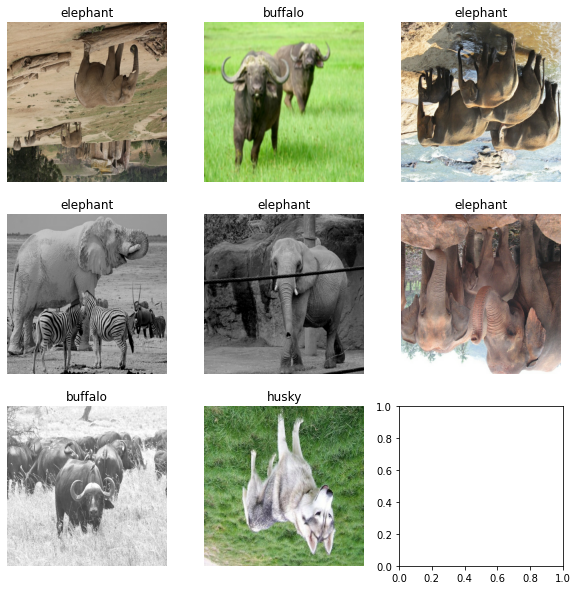

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [29]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 480, 480, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 480, 480, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 240, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 64)       

# TRY 1

## Train the model

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
682/682 [==============================] - 816s 1s/step - loss: 1.3636 - accuracy: 0.4262 - val_loss: 1.3336 - val_accuracy: 0.4106
Epoch 2/10
682/682 [==============================] - 859s 1s/step - loss: 0.8764 - accuracy: 0.6590 - val_loss: 1.3587 - val_accuracy: 0.4743
Epoch 3/10
682/682 [==============================] - 938s 1s/step - loss: 0.3074 - accuracy: 0.8955 - val_loss: 1.9534 - val_accuracy: 0.5145
Epoch 4/10
682/682 [==============================] - 953s 1s/step - loss: 0.0840 - accuracy: 0.9762 - val_loss: 2.5451 - val_accuracy: 0.5140
Epoch 5/10
682/682 [==============================] - 947s 1s/step - loss: 0.0439 - accuracy: 0.9868 - val_loss: 3.1464 - val_accuracy: 0.5272
Epoch 6/10
682/682 [==============================] - 944s 1s/step - loss: 0.0393 - accuracy: 0.9886 - val_loss: 3.6757 - val_accuracy: 0.5012
Epoch 7/10
682/682 [==============================] - 939s 1s/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 3.4450 - val_accuracy: 0.5385

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

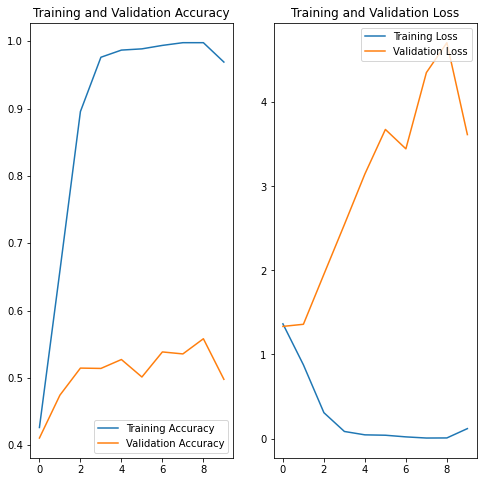

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save("my_model1")

INFO:tensorflow:Assets written to: my_model1\assets


<h1 style="color:Tomato;">
Its a Overfitting Model

## More Data augmentation from Keras documentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

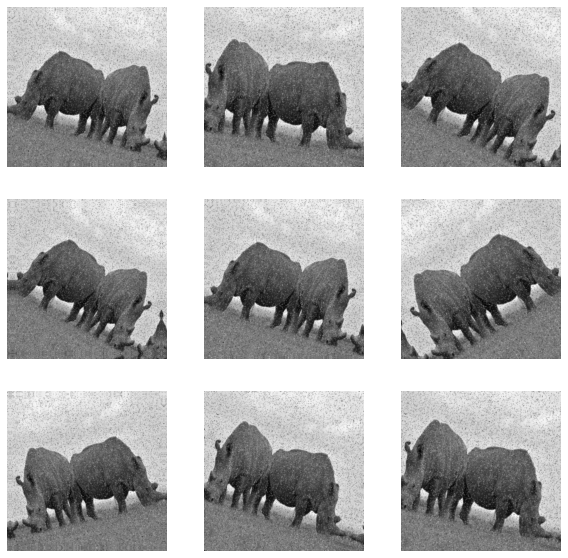

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## I Have used Dropout to avoid overfitting, mestioned link below for further reference

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [37]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 480, 480, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 480, 480, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 480, 480, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 240, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 120, 120, 64)     

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
682/682 [==============================] - 1098s 2s/step - loss: 1.4341 - accuracy: 0.4123 - val_loss: 1.3497 - val_accuracy: 0.4042
Epoch 2/15
682/682 [==============================] - 1095s 2s/step - loss: 1.1865 - accuracy: 0.4968 - val_loss: 1.3008 - val_accuracy: 0.4375
Epoch 3/15
682/682 [==============================] - 617s 904ms/step - loss: 1.0973 - accuracy: 0.5523 - val_loss: 1.2450 - val_accuracy: 0.4826
Epoch 4/15
682/682 [==============================] - 562s 824ms/step - loss: 1.0352 - accuracy: 0.5765 - val_loss: 1.2650 - val_accuracy: 0.4958
Epoch 5/15
682/682 [==============================] - 573s 839ms/step - loss: 0.9853 - accuracy: 0.6042 - val_loss: 1.1941 - val_accuracy: 0.5218
Epoch 6/15
682/682 [==============================] - 547s 803ms/step - loss: 0.9104 - accuracy: 0.6275 - val_loss: 1.2047 - val_accuracy: 0.5125
Epoch 7/15
682/682 [==============================] - 548s 804ms/step - loss: 0.8612 - accuracy: 0.6598 - val_loss: 1.1129 - val

In [41]:
model.save("my_model2")

INFO:tensorflow:Assets written to: my_model2\assets


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

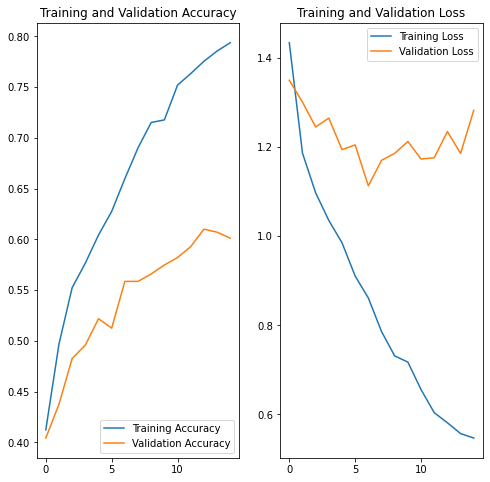

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1 style="color:Tomato;">
approach 2

In [43]:
new_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'), 
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'), 
  layers.Dense(32, activation='relu'),
  layers.Dense(32, activation='relu'),  
  layers.Dense(num_classes)
])

In [44]:
new_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 480, 480, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 480, 480, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 480, 480, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 240, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 120, 120, 64)     

In [46]:
epochs = 50
history = new_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
682/682 [==============================] - 551s 807ms/step - loss: 1.4782 - accuracy: 0.3082 - val_loss: 1.4762 - val_accuracy: 0.3836
Epoch 2/50
682/682 [==============================] - 546s 801ms/step - loss: 1.3388 - accuracy: 0.4002 - val_loss: 1.3786 - val_accuracy: 0.4385
Epoch 3/50
682/682 [==============================] - 565s 828ms/step - loss: 1.2666 - accuracy: 0.4427 - val_loss: 1.4197 - val_accuracy: 0.4032
Epoch 4/50
682/682 [==============================] - 544s 798ms/step - loss: 1.2332 - accuracy: 0.4667 - val_loss: 1.2921 - val_accuracy: 0.4356
Epoch 5/50
682/682 [==============================] - 545s 799ms/step - loss: 1.1814 - accuracy: 0.5027 - val_loss: 1.3326 - val_accuracy: 0.4179
Epoch 6/50
682/682 [==============================] - 545s 798ms/step - loss: 1.1338 - accuracy: 0.5241 - val_loss: 1.2027 - val_accuracy: 0.5027
Epoch 7/50
682/682 [==============================] - 19275s 28s/step - loss: 1.0632 - accuracy: 0.5621 - val_loss: 1.1605 -

In [47]:
new_model.save("my_new_model2")

INFO:tensorflow:Assets written to: my_new_model2\assets


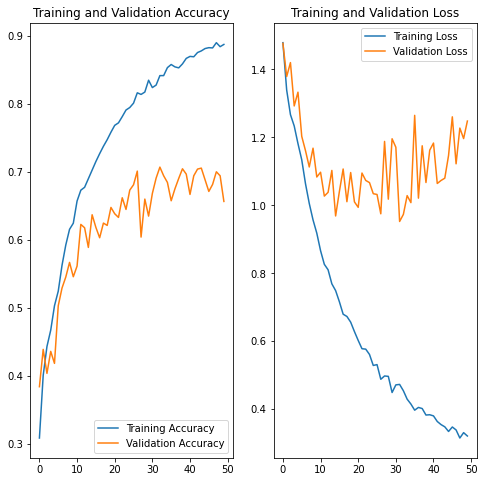

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

-------------------------------------------
The name of the below file is Images\beagle (140)_gblur.jpg


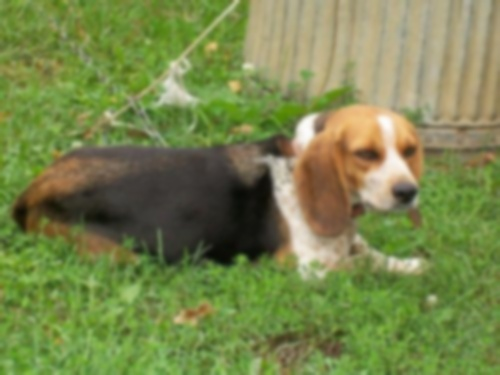

The Above image most likely belongs to beagle with a 99.99 percent confidence.
-------------------------------------------
The name of the below file is Images\beagle (143).jpg


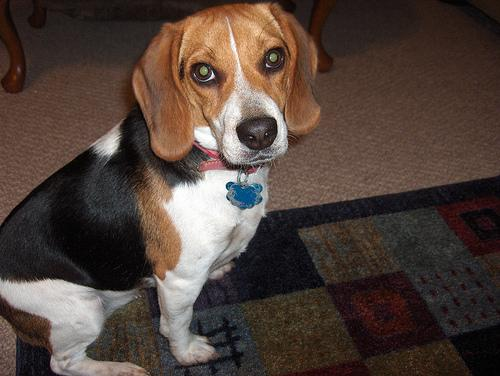

The Above image most likely belongs to husky with a 52.10 percent confidence.
-------------------------------------------
The name of the below file is Images\beagle (184)_flip_v.jpg


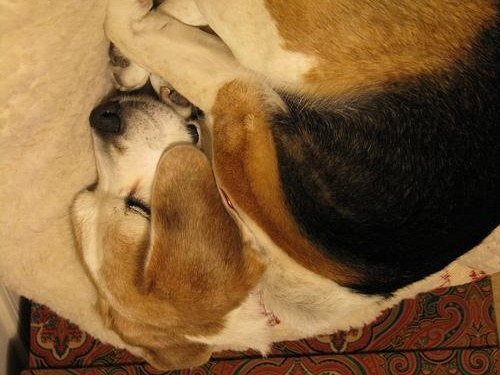

The Above image most likely belongs to beagle with a 98.63 percent confidence.
-------------------------------------------
The name of the below file is Images\beagle (186)_gblur.jpg


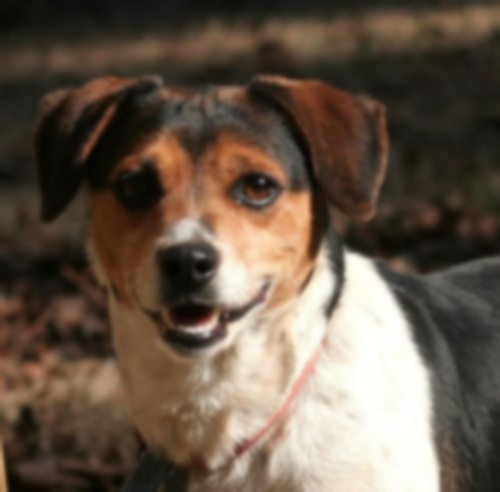

The Above image most likely belongs to beagle with a 99.35 percent confidence.
-------------------------------------------
The name of the below file is Images\buffalo (10)_gblur.jpg


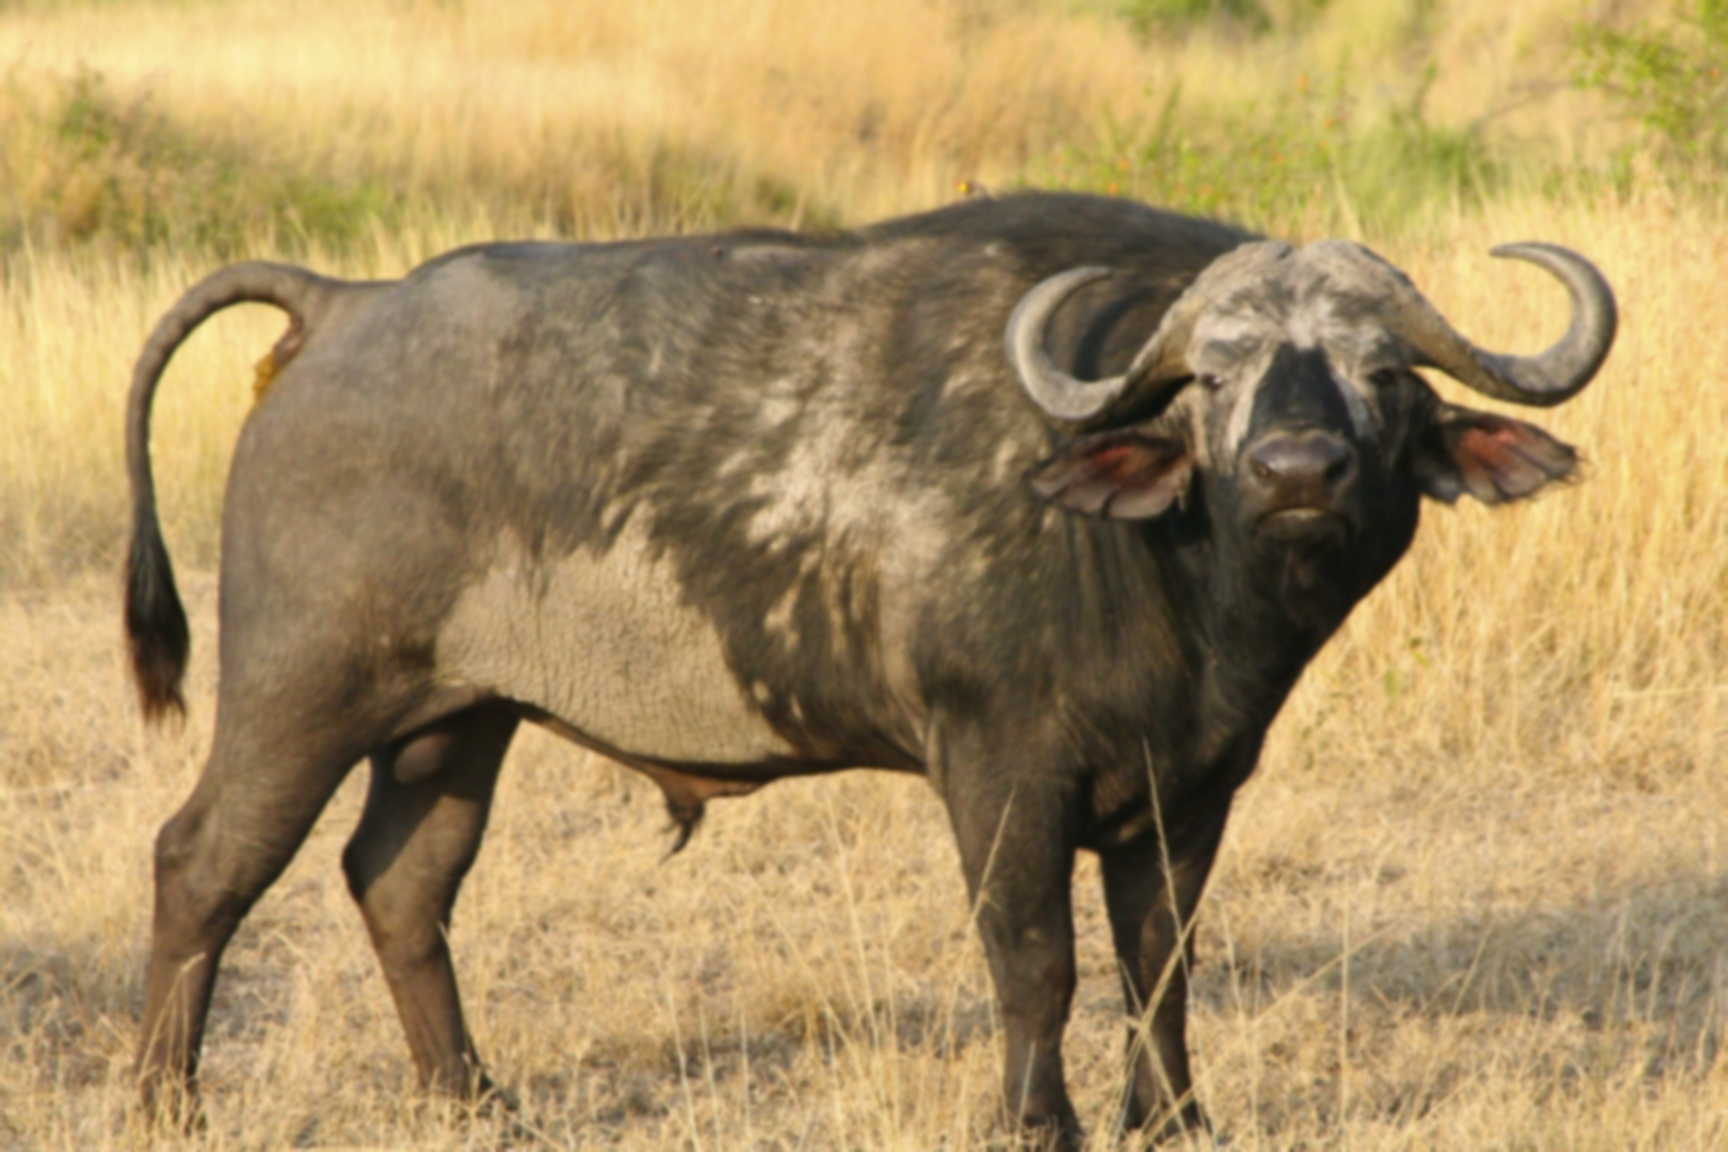

The Above image most likely belongs to buffalo with a 100.00 percent confidence.
-------------------------------------------
The name of the below file is Images\buffalo (12)_gblur.jpg


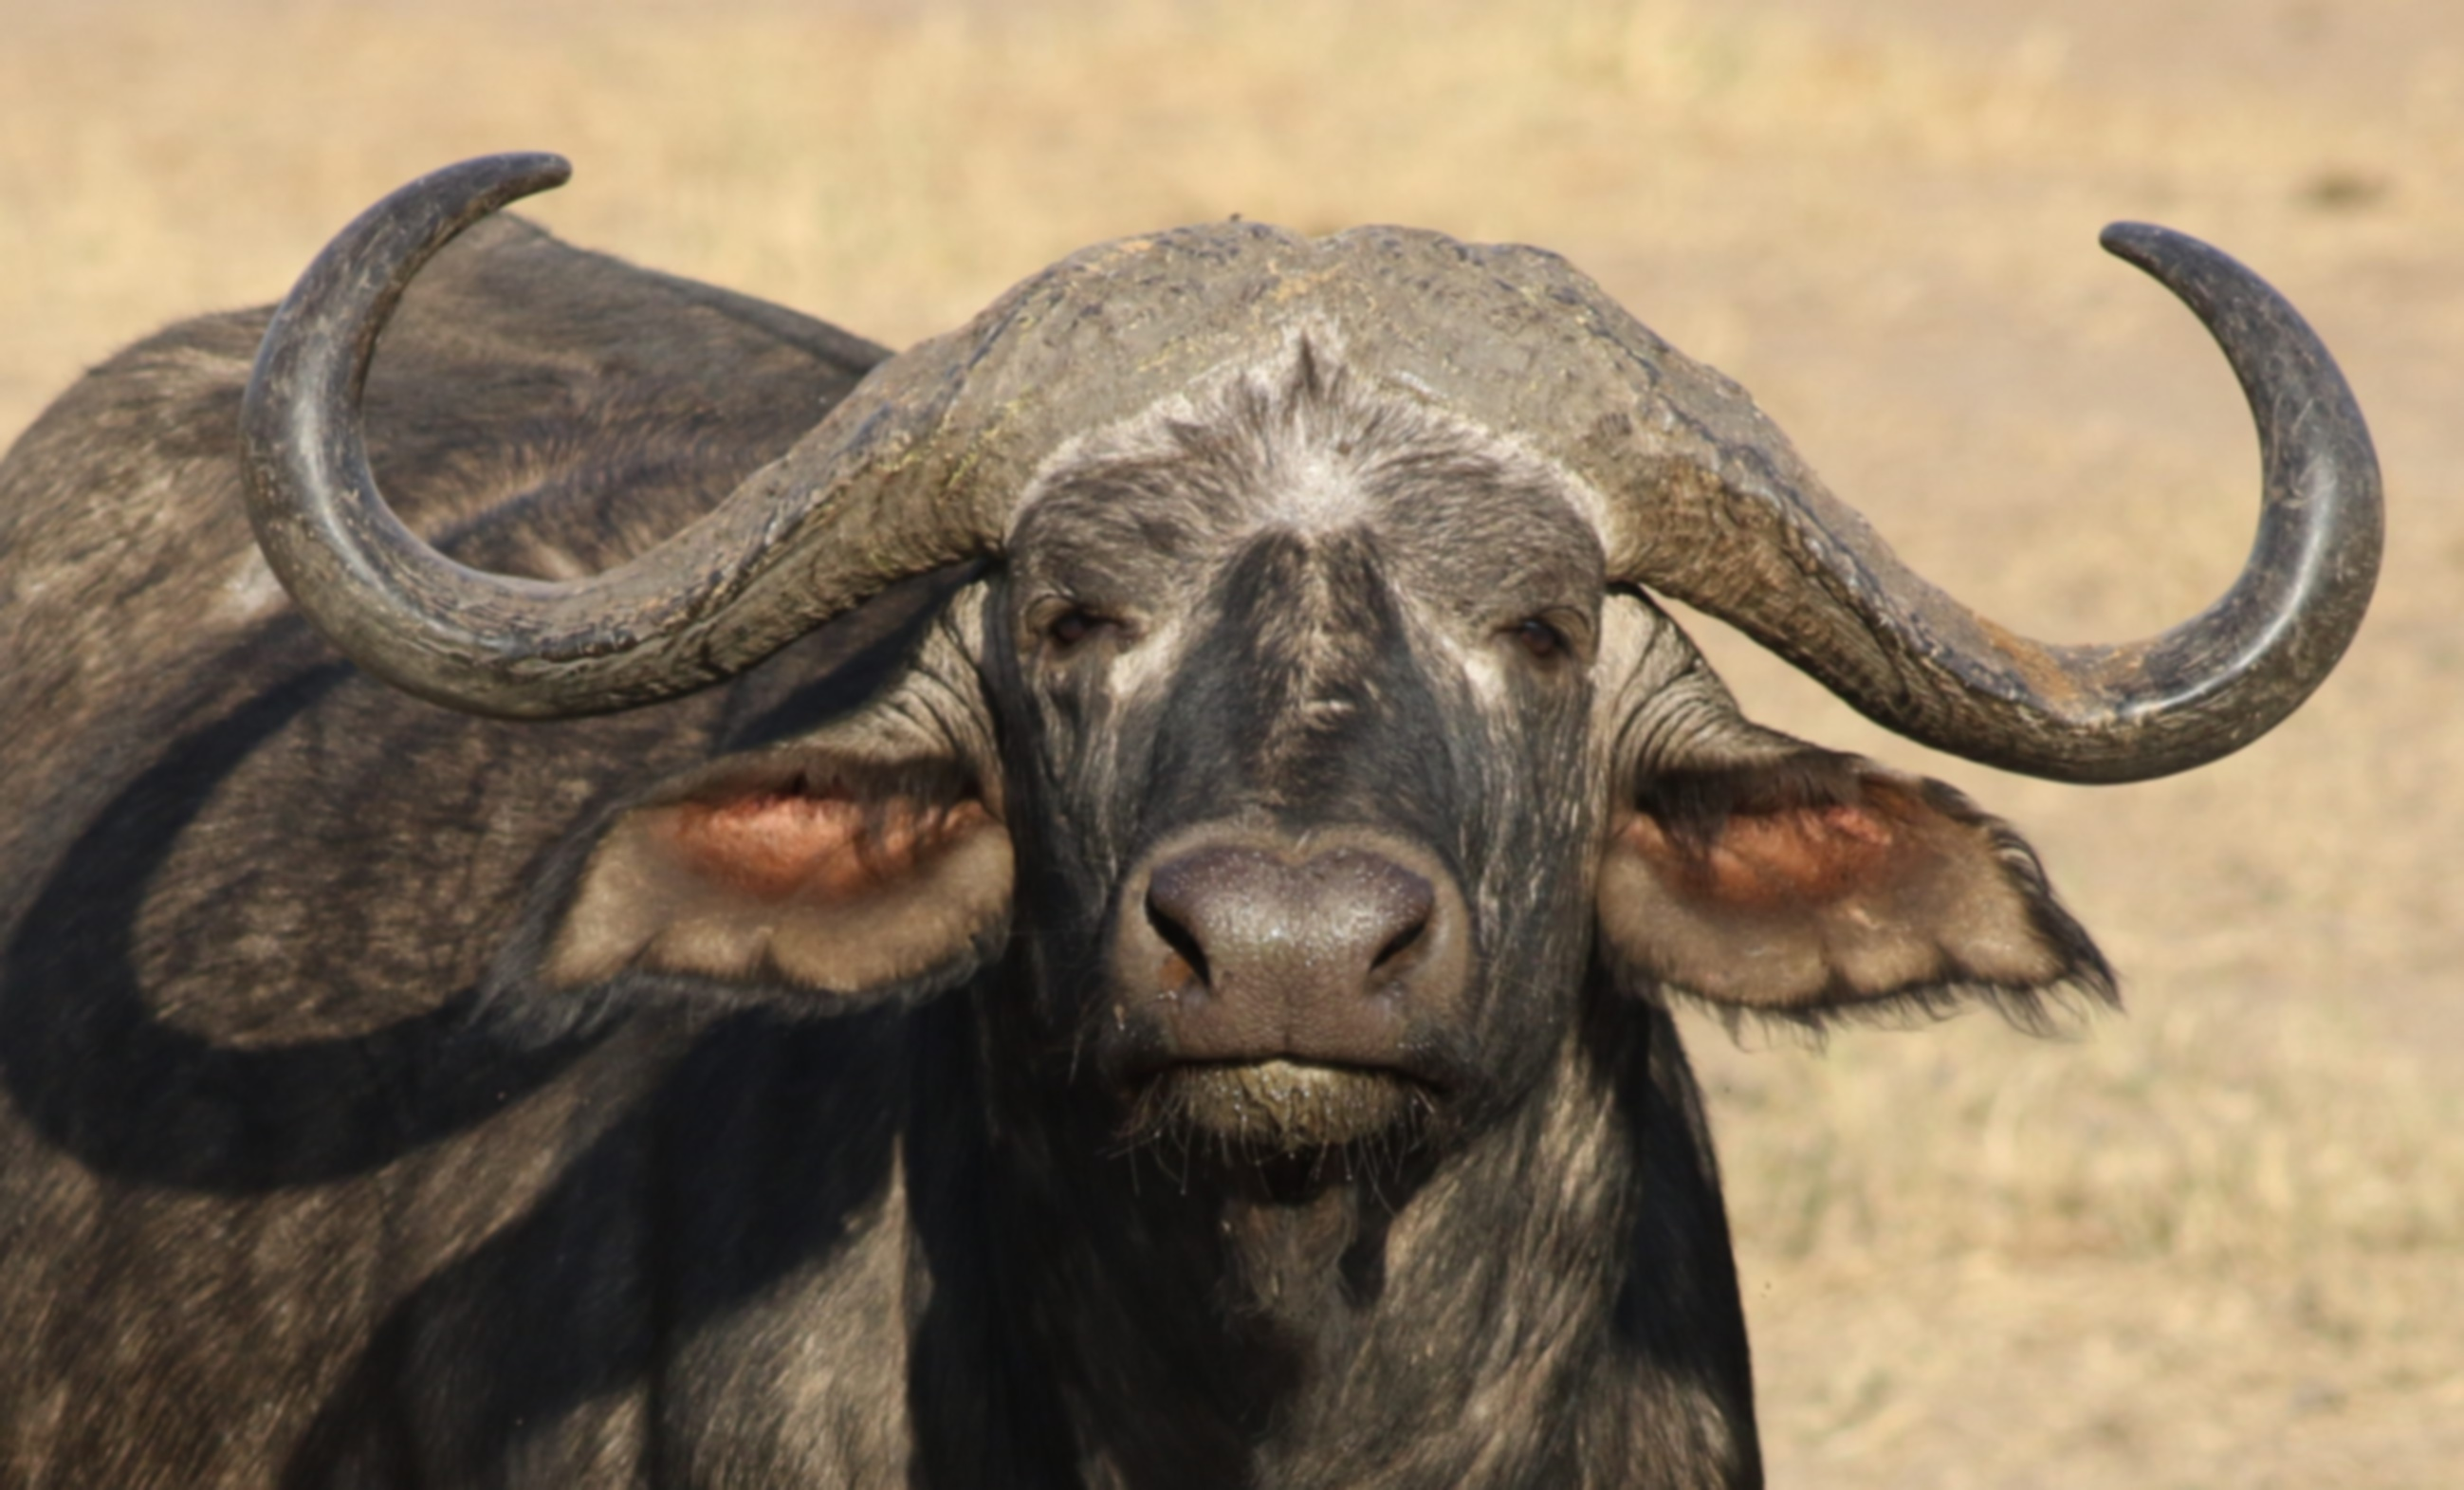

The Above image most likely belongs to buffalo with a 99.97 percent confidence.
-------------------------------------------
The name of the below file is Images\elephant (1)_gblur.jpg


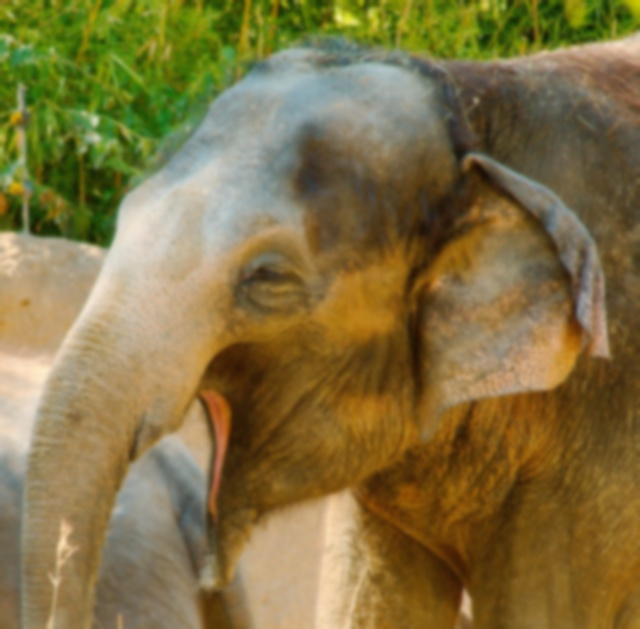

The Above image most likely belongs to elephant with a 98.49 percent confidence.
-------------------------------------------
The name of the below file is Images\elephant (3)_gblur.jpg


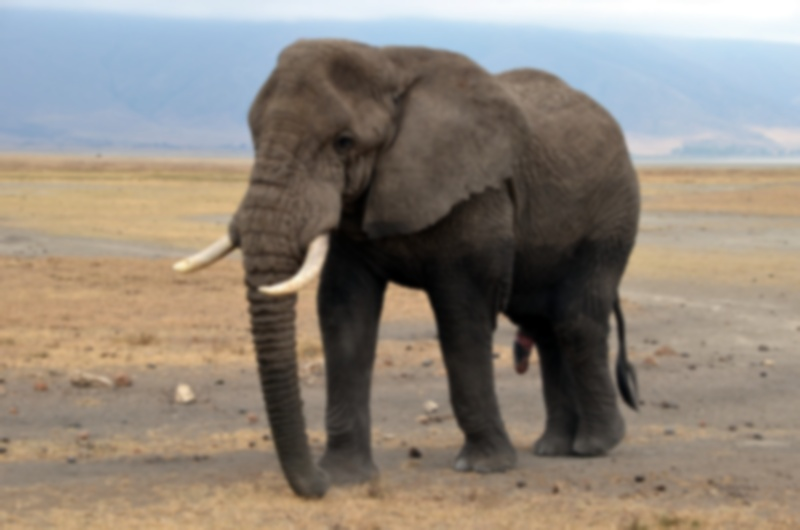

The Above image most likely belongs to elephant with a 99.60 percent confidence.
-------------------------------------------
The name of the below file is Images\elephant (8)_flip_h.jpg


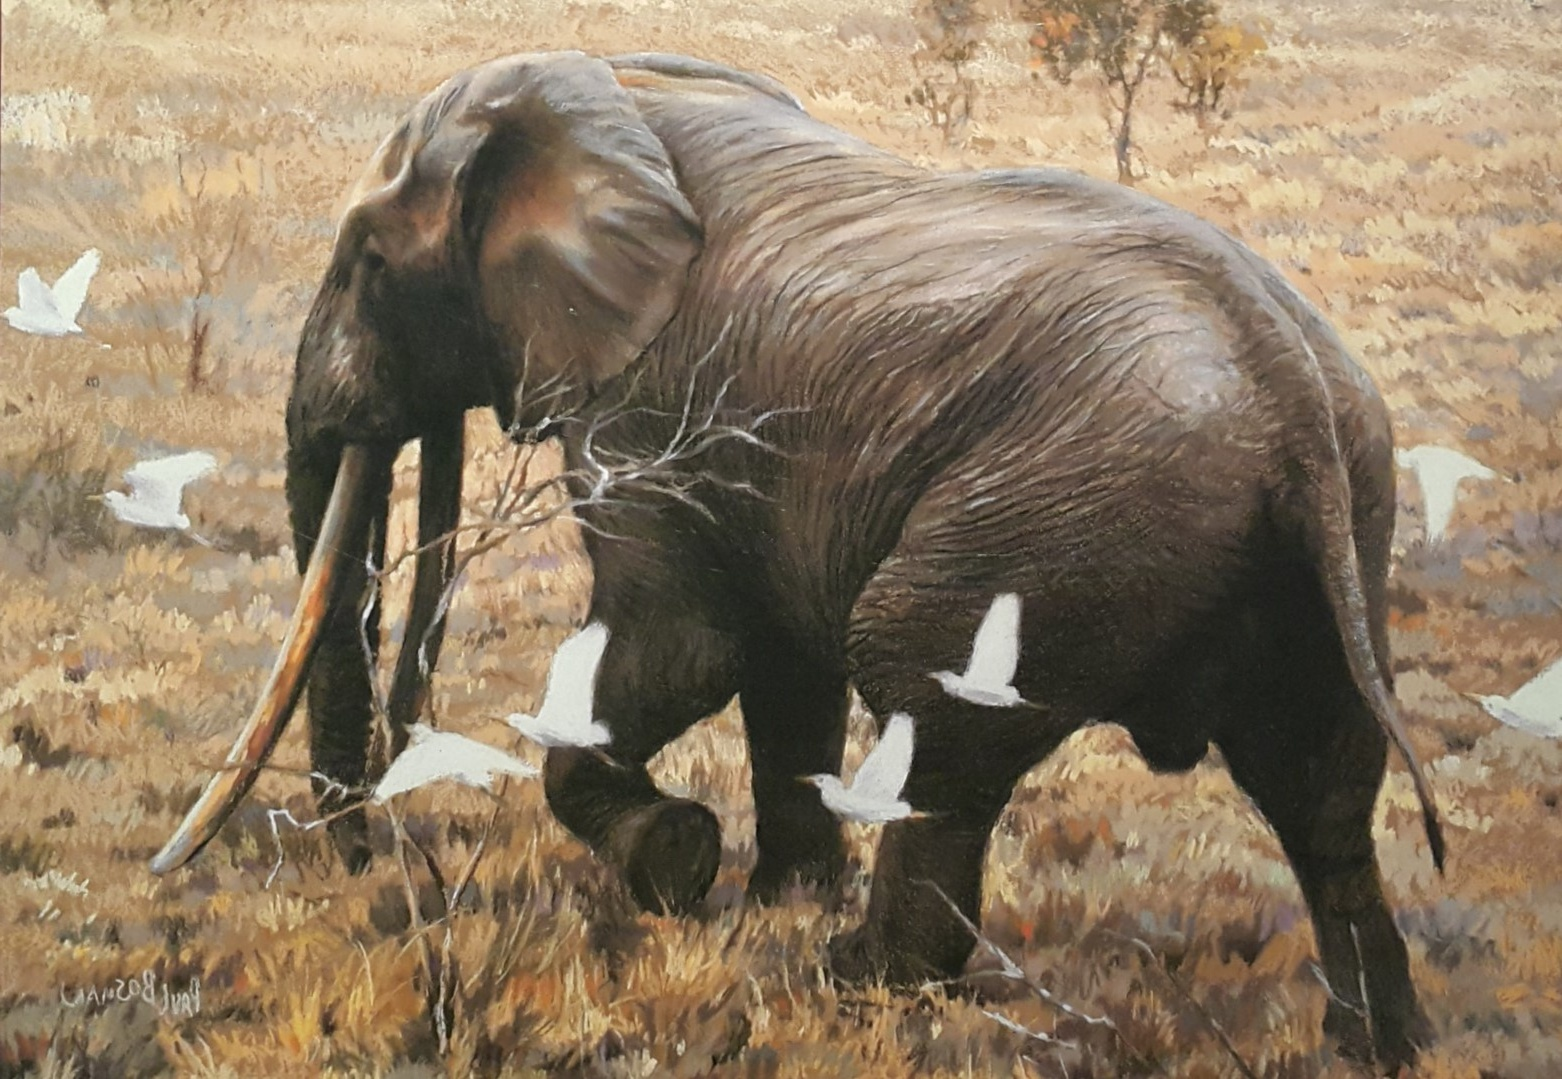

The Above image most likely belongs to elephant with a 71.76 percent confidence.
-------------------------------------------
The name of the below file is Images\husky (5).jpg


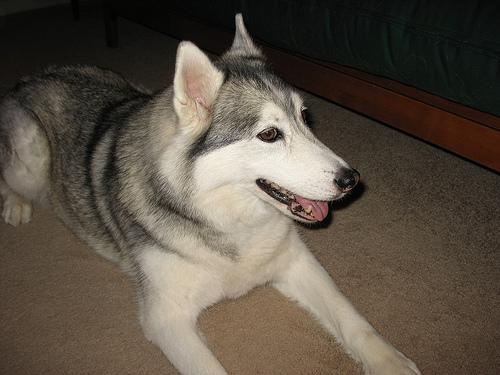

The Above image most likely belongs to husky with a 100.00 percent confidence.
-------------------------------------------
The name of the below file is Images\husky (5)_gblur.jpg


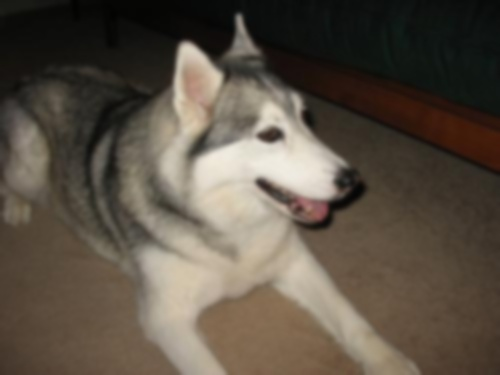

The Above image most likely belongs to husky with a 100.00 percent confidence.
-------------------------------------------
The name of the below file is Images\rhino (76)_gblur.jpg


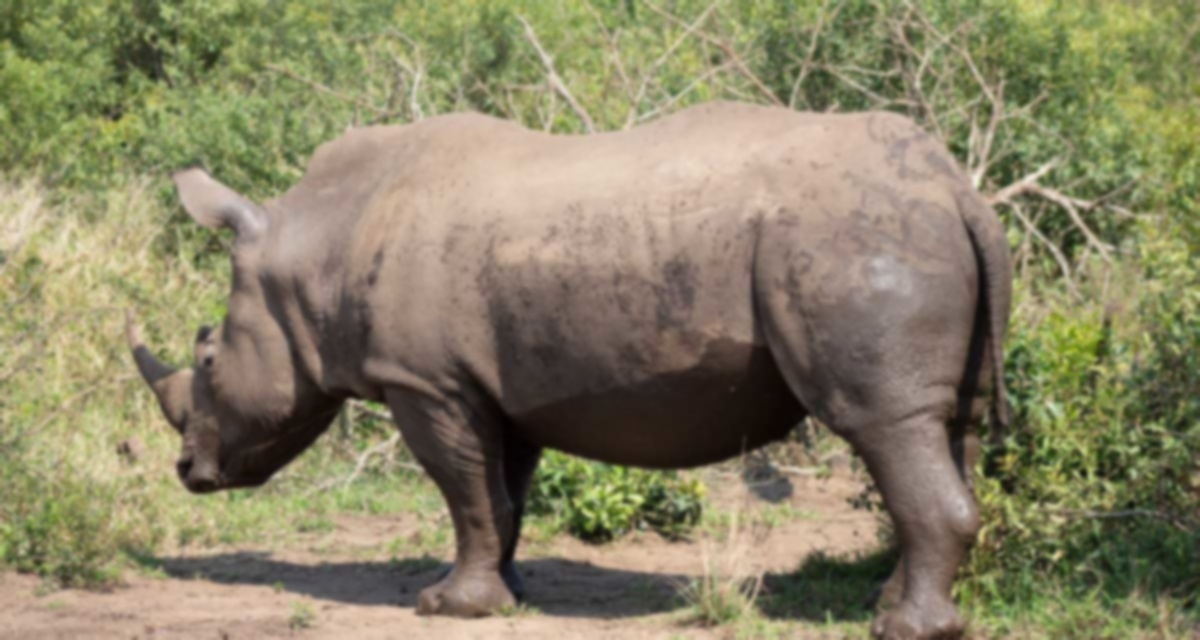

The Above image most likely belongs to rhino with a 94.09 percent confidence.
-------------------------------------------
The name of the below file is Images\rhino (82).jpg


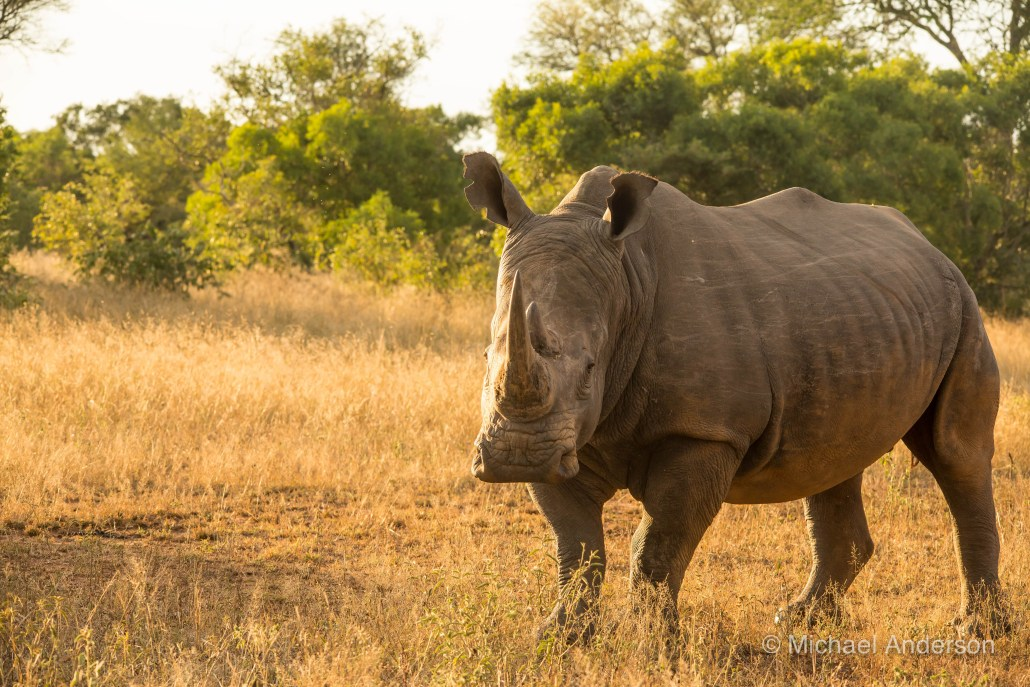

The Above image most likely belongs to rhino with a 97.81 percent confidence.
-------------------------------------------
The name of the below file is Images\rhino (87).jpg


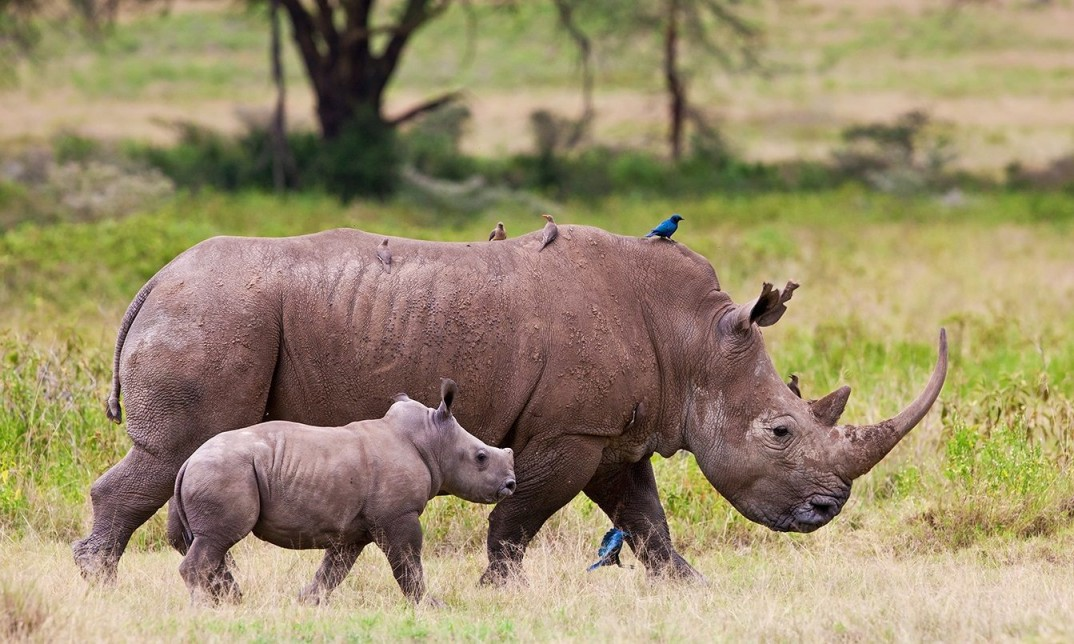

The Above image most likely belongs to rhino with a 88.99 percent confidence.


In [65]:
from IPython.display import Image
import glob, shutil

for filepath in glob.iglob('Images/*.jpg'):
    print("-------------------------------------------")
    print("The name of the below file is "+filepath)
    img = keras.preprocessing.image.load_img(filepath, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    display(Image(filename=filepath))
    predictions = new_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("The Above image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))